<a href="https://colab.research.google.com/github/kay-kay-t/CodingDojo/blob/main/01_Intro_to_Gradient_Boosting_Assignment_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Gradient Boosting

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [169]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

The data is available [here](https://drive.google.com/file/d/1drlRzq-lIY7rxQnvv_3fsxfIfLsjQ4A-/view?usp=sharing)

In [171]:
df = pd.read_csv('/content/drive/MyDrive/Data/census_income.csv')
df

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,32556,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,32557,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,32559,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Prepare your dataset for modeling.

Remember to: 
1. Check for missing data or bad data.
2. Check your target class balance
3. Any other data preparation you think might improve your model performance 
4. Dummy encode categorical values.  You can find the names of all of the columns with categorical data with the following code:
`categorical_cols = X.select_dtypes(include='object').columns`.

[Here is the documentaion](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) for `df.select_dtypes()`

In [172]:
# Checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income-class    32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [173]:
# Checking if there any duplicates
df.duplicated().any()

False

Per output above there's no duplicates in dataset.


In [174]:
#Dropping Unnamed column
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [175]:
# category_selector = make_column_selector(dtype_include='object')
# for col in df.columns:
#   if col == category_selector:
#     print(df[col].value_counts())

In [176]:
# Using for loop to check all data frame for inconsistent values
for col in df.columns:
    print(df[col].value_counts())

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse     

Per output above there's some missing values marked withy '?'. Let's replace tem with Nan so we can drop them later on.

In [177]:
# Identifing missing values amount
df.isin(['?']).sum()

age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income-class         0
dtype: int64

In [178]:
# Replacing '?' with Nan and dropping them
df.replace(to_replace='?', value=np.nan, inplace=True)
df.dropna(inplace=True)

In [179]:
# Confirming there's no missing values
df.isnull().sum()

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income-class      0
dtype: int64

In [180]:
# Checking target balance
df['income-class'].value_counts(normalize=True)

<=50K    0.751078
>50K     0.248922
Name: income-class, dtype: float64

Since data is not really balanced, we are going to use stratify later on.

In [181]:
# Binarize target column
df['income-class'] = df['income-class'].map({'<=50K': 0, '>50K': 1})
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [182]:
# Finding categotical col
categorical_cols = df.select_dtypes(include='object').columns
print(categorical_cols)

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')


In [183]:
# Dummy encoding 
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 
                             'relationship', 'race', 'sex', 'native-country'], drop_first=True)
df.head()

,age,capital-gain,capital-loss,hours-per-week,income-class,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,2174,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,0,0,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,0,0,40,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [186]:
# Assigning target and features
y = df['income-class']
X =df.drop(columns = 'income-class')

In [187]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [188]:
# Scaling data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [205]:
%%time
# Instantiate and fit gradient boosting classifier
xgb = XGBClassifier()
xgb.fit(X_train_sc, y_train)
print('Training accuracy:', xgb.score(X_train_sc, y_train))
print('Testing accuracy:', xgb.score(X_test_sc, y_test))

Training accuracy: 0.8634012643119225
Testing accuracy: 0.8543959687044158
CPU times: user 4.56 s, sys: 32.4 ms, total: 4.59 s
Wall time: 4.59 s


Model did alright on training and testing sets. Acurracy of 85-86% with difference of 1% between sets, that means this model is slightly overfit, but pretty accurate. 

In [206]:
# Report
y_pred = xgb.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5664
           1       0.78      0.58      0.66      1877

    accuracy                           0.85      7541
   macro avg       0.83      0.76      0.79      7541
weighted avg       0.85      0.85      0.85      7541



Which target class is your model better at predicting?  Is it significantly overfit?

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

In [207]:
%%time
# Instantiate and fit gradient boosting classifier
lgbm = LGBMClassifier()
lgbm.fit(X_train_sc, y_train)
print('Training accuracy:', lgbm.score(X_train_sc, y_train))
print('Testing accuracy:', lgbm.score(X_test_sc, y_test))


Training accuracy: 0.8836479377569515
Testing accuracy: 0.8652698581090041
CPU times: user 1.7 s, sys: 15.4 ms, total: 1.71 s
Wall time: 1.71 s


In [208]:
# Report
y_pred = lgbm.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5664
           1       0.77      0.65      0.71      1877

    accuracy                           0.87      7541
   macro avg       0.83      0.79      0.81      7541
weighted avg       0.86      0.87      0.86      7541



This model is more overfit than the one above, however run time is less and accuracy is better.

## GradientBoostingClassifier

In [209]:
%%time
# Instantiate and fit gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sc, y_train)
print('Training accuracy:', gbc.score(X_train_sc, y_train))
print('Testing accuracy:', gbc.score(X_test_sc, y_test))

Training accuracy: 0.8665399407630078
Testing accuracy: 0.8562524864076383
CPU times: user 4.34 s, sys: 4.3 ms, total: 4.35 s
Wall time: 4.33 s


In [210]:
# Report
y_pred = gbc.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5664
           1       0.79      0.58      0.67      1877

    accuracy                           0.86      7541
   macro avg       0.83      0.76      0.79      7541
weighted avg       0.85      0.86      0.85      7541



Gradient Boosting model has 86% accuracy, slightly overfit and on the second spot by runtime. 

I would say LGBM model has optimal outputs and run time.

# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


In [222]:
params = {'num_leaves': [5, 15, 25, 30], 'max_depth': [2, 3, 4, 5], 'learning_rate':[0.1, 0.2, 0.3, 0.4], 'n_estimators': [50, 100, 150, 200]}
gs = GridSearchCV(LGBMClassifier(), params, cv=3, return_train_score=True)
gs.fit(X_train_sc, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_

In [223]:
# Finding best params
gs.best_params_

{'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 200, 'num_leaves': 5}

In [227]:
%%time
# Instantiate and fit lgbm with optimal params
lgbm = LGBMClassifier(learning_rate=0.4, max_depth=2, n_estimators=200, num_leaves=5)
lgbm.fit(X_train_sc, y_train)
print('Training accuracy:', lgbm.score(X_train_sc, y_train))
print('Testing accuracy:', lgbm.score(X_test_sc, y_test))

Training accuracy: 0.8765306573537863
Testing accuracy: 0.8616894311099323
CPU times: user 1.9 s, sys: 5.96 ms, total: 1.91 s
Wall time: 1.92 s


In [228]:
# Report
y_pred = gbc.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5664
           1       0.79      0.58      0.67      1877

    accuracy                           0.86      7541
   macro avg       0.83      0.76      0.79      7541
weighted avg       0.85      0.86      0.85      7541



With tunning we decreased overfitting, however runtime slightly increased and accuracy droped by 1%.

# Evaluation

Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5664
           1       0.77      0.63      0.69      1877

    accuracy                           0.86      7541
   macro avg       0.83      0.78      0.80      7541
weighted avg       0.86      0.86      0.86      7541



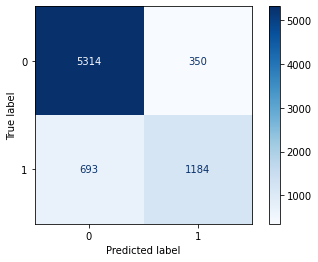

In [232]:
y_pred = lgbm.predict(X_test_sc)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgbm, X_test_sc, y_test, cmap = 'Blues', values_format='.0f', );

So out of those three models Light GBM gives the best performing with shorter runtime. Based on our predictions, there's more chances person will make less than 50K per year.

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

